The RandomizedLogisticRegression is not stable between kernels.
Just create a notebook and do all the analysis + print output to files,
So yoiu won't have problem on making the figures

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Read HDF file and phenotypes

In [5]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


Since it is the first analysis I will do some data exploration

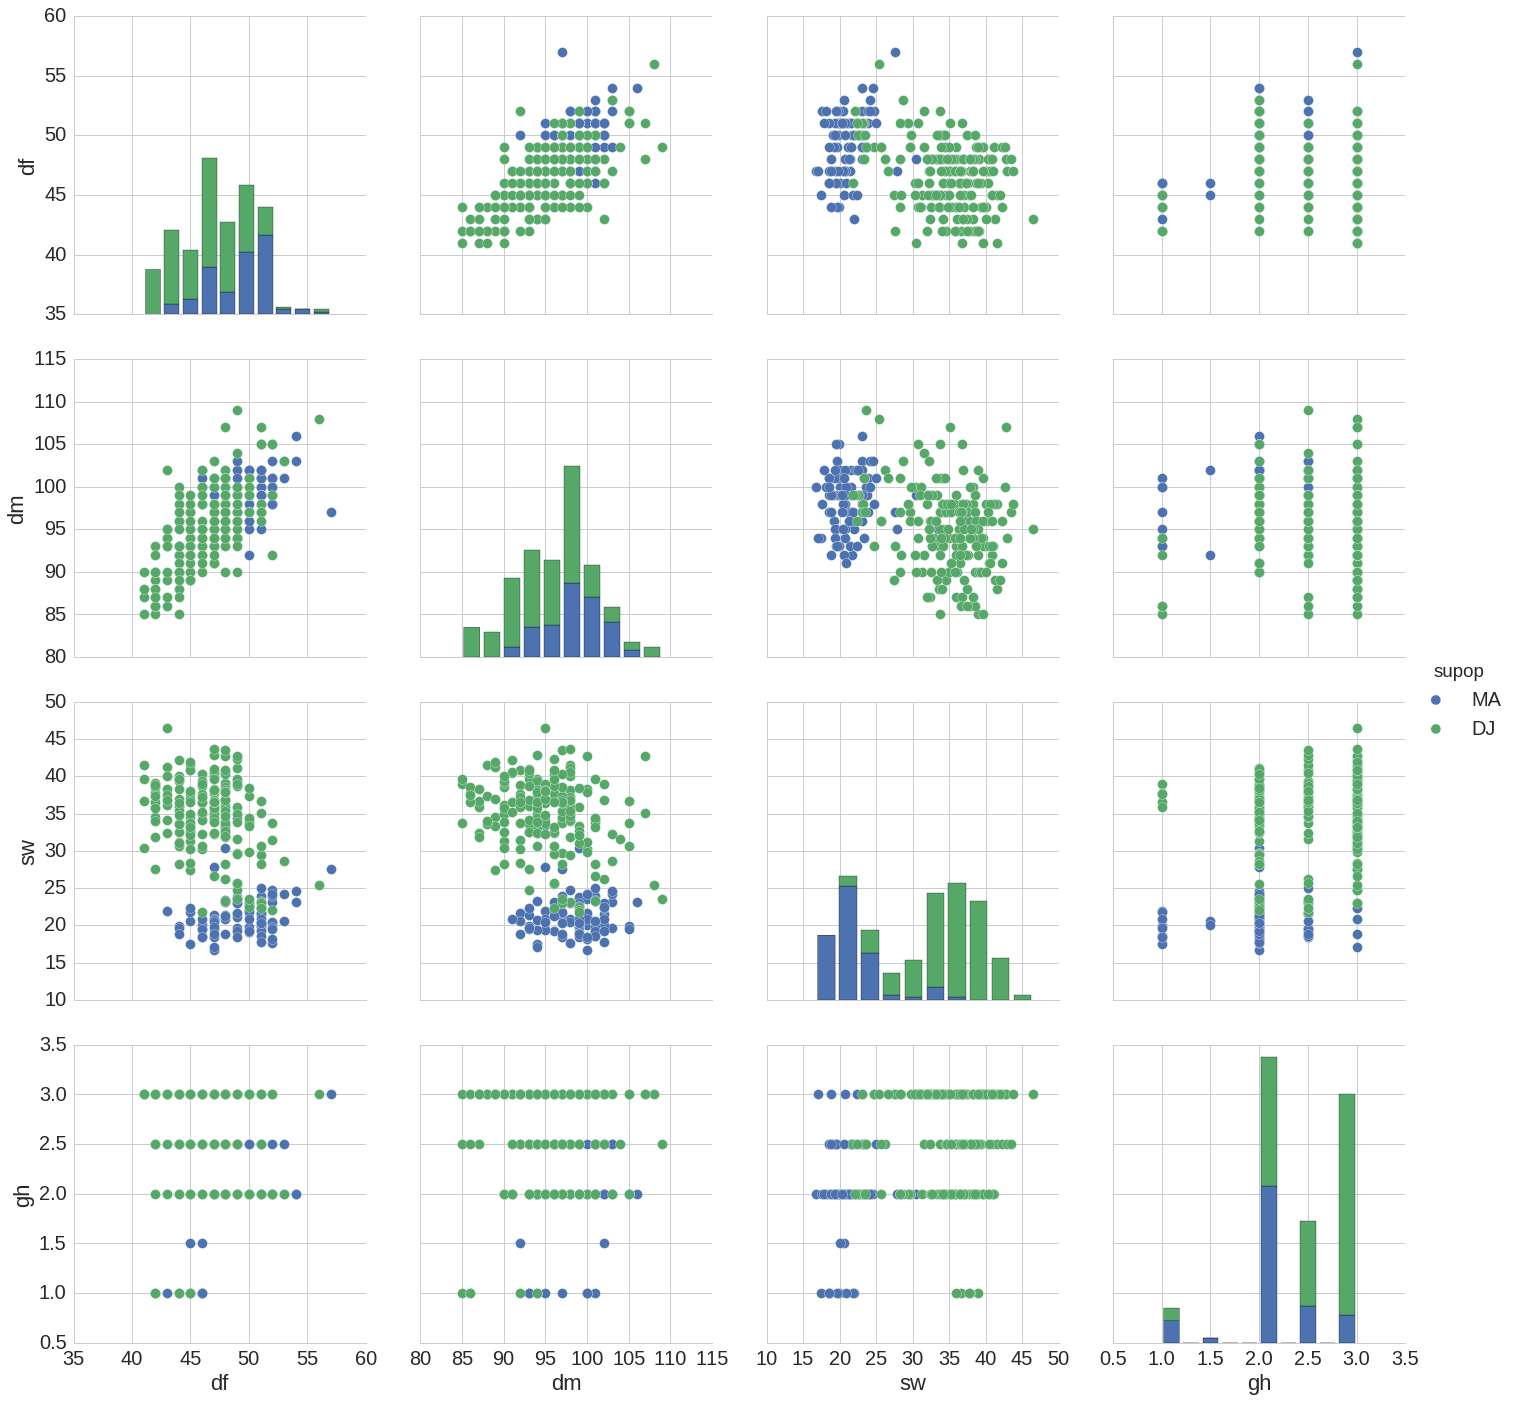

In [5]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.pairplot(pheno_all[['df', 'dm', 'sw', 'gh', 'supop']], hue='supop', size=5, 
             plot_kws={'s':100});

# All collection

Prepare phenotypes and genotypes for ML training

I will use the cross_val_score with **scorer='precision_micro'** for the classification. Then I will plot two graphs (1 DF and 1 DM) with mean +- std of the cv values (use 5 cv)

Create funcion with all the data in the model_prescreen script. N.B. for precision you should use a `make_scorer(precision_score, average=average)` like for precision_recall curve.
return a dataframe with all the prediction x classifier, so you can plot it with seaborn point_plot

I will analyze
1. Early (25 %)
2. Late (75 %)
3. 3 Classes

In [71]:
# import custom module
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2, mutual_info_classif, SelectFromModel

## Feature selection approach

In [88]:
def feature_selector(X,y):
    selector = SelectPercentile(mutual_info_classif(X,y, random_state=42), percentile = 5)
    #selector.fit(X,y)
    return selector

## Stratify byclass

## Early 25%

In [89]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

lg1 = LogisticRegression(penalty='l1', random_state=42)

X_train_s = feature_selector(X_train, y_train).transform(X_train)

print(X_train_s.shape)
classification_prescreen_early = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                           cv = 5, jobs=7)

KeyboardInterrupt: 

## Late 25

In [ ]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

lg2 = LogisticRegression(penalty='l1', random_state=42)

X_train_s = feature_selector(X_train, y_train, lg2).transform(X_train)

classification_prescreen_late = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                          cv = 5, jobs=7)

## 3 classes

In [ ]:
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

lg3 = LogisticRegression(penalty='l1', random_state=42)

X_train_s = feature_selector(X_train, y_train, lg3).transform(X_train)

classification_prescreen_all = classification_task_score(X_train_s, y_train, 
                                                     strat=y_train, scorer='precision_macro',
                                                         cv = 5, jobs=7)

In [ ]:
# plot both
sns.set(font_scale=2)
sns.set_style("whitegrid")
classification_prescreen_early['Class']=np.repeat('Early', classification_prescreen_early.shape[0])
classification_prescreen_late['Class']=np.repeat('Late', classification_prescreen_late.shape[0])
classification_prescreen_all['Class']=np.repeat('3 Classes', classification_prescreen_all.shape[0])
classification_df = pd.concat([classification_prescreen_early, 
                       classification_prescreen_late, classification_prescreen_all])


sns.pointplot(x='Classifier_ID', y='Score', hue='Class',
                   data = classification_df, dodge=True)
plt.ylabel('Precision')
plt.title('Days to flowering')
#plt.ylim((0,1))
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5));

In [42]:
# save DF to file so you can plot again later
classification_df.to_csv('CV_DF_prediction.csv', sep=',', header=True, index=False)

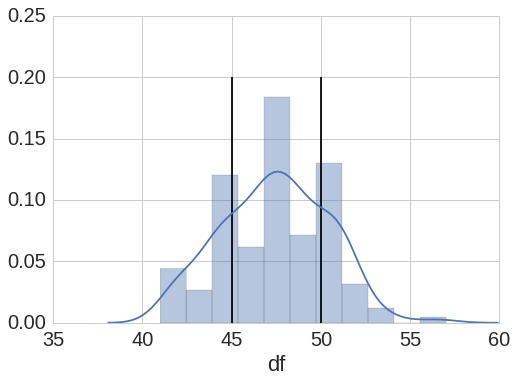

In [18]:
sns.distplot(df)
plt.vlines(np.percentile(df, 25), 0, .20)
plt.vlines(np.percentile(df, 75), 0, .20);

It seems that the best performance is achieved for 3 classes
I will start with two classes and the following algorithms using **precision_macro**:

1. linear_SVC

2. Logit

3. SGD??


# Prepare data-3 classes

Prepare data

In [90]:
from sklearn.metrics import precision_score, f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df = pheno_all['df']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101)

# create function for evaluatin shit
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(precision_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)


def feature_selector(X,y, model):
    model.fit(X,y)
    selector = SelectFromModel(model, threshold=0.001, prefit=True)
    return selector

lgSelect = LogisticRegression(penalty='l1', random_state=42)

selector = feature_selector(X_train, y_train, lgSelect)
X_train_s = selector.transform(X_train)
print(X_train_s.shape)

(224, 1317)


## Logit 

In [91]:
from sklearn.linear_model import LogisticRegression

lg_default = LogisticRegression(random_state=42)
y_pred = report_res(lg_default, X_train_s, y_train, 'macro')
#lg_default.fit(X_train_s, y_train)

1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        62
          1       1.00      1.00      1.00       122
          2       1.00      1.00      1.00        40

avg / total       1.00      1.00      1.00       224



In [70]:
X_test_s = selector.transform(X_test)

y_test_pred = lg_default.predict(X_test_s)
print(precision_score(y_test, y_test_pred, average='macro'))
print(classification_report(y_test, y_test_pred))

0.678321678322
             precision    recall  f1-score   support

          0       0.73      0.50      0.59        16
          1       0.64      0.83      0.72        30
          2       0.67      0.40      0.50        10

avg / total       0.67      0.66      0.65        56



In [95]:
np.logspace(-4,2,10)

array([  1.00000000e-04,   4.64158883e-04,   2.15443469e-03,
         1.00000000e-02,   4.64158883e-02,   2.15443469e-01,
         1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02])

In [96]:
param_grid = {'penalty':['l2'],'solver':['liblinear'], 'C':np.logspace(-4,2,10),
              'class_weight': [None, 'balanced'],
              'dual':[False, True], 'tol': np.logspace(-5,-1, 5), 'max_iter':np.linspace(100,500,4)
             }

lg = LogisticRegression(random_state=42, n_jobs=6)

lg_search_param = GridSearchCV(lg,param_grid=param_grid,
                                   scoring='precision_macro',n_jobs=6,iid=False,
                                   cv=5)
lg_search_param.fit(X_train_s, y_train)
print(lg_search_param.best_params_)
print(lg_search_param.best_estimator_)

y_pred=report_res(lg_search_param, X_train_s, y_train, 'macro')

{'class_weight': None, 'dual': False, 'max_iter': 100.0, 'C': 0.046415888336127774, 'solver': 'liblinear', 'penalty': 'l2', 'tol': 0.10000000000000001}
LogisticRegression(C=0.046415888336127774, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100.0,
          multi_class='ovr', n_jobs=6, penalty='l2', random_state=42,
          solver='liblinear', tol=0.10000000000000001, verbose=0,
          warm_start=False)
0.9972899729
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        62
          1       0.99      1.00      1.00       122
          2       1.00      0.97      0.99        40

avg / total       1.00      1.00      1.00       224



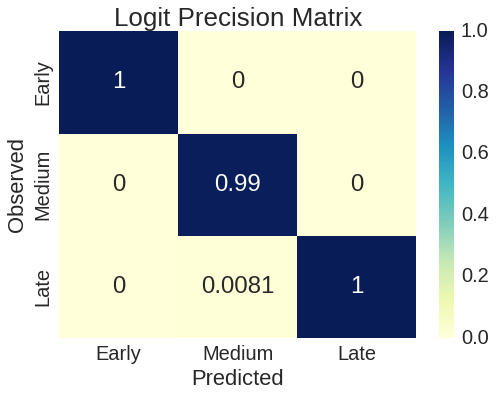

In [97]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Medium', 'Late'],
           yticklabels = ['Early', 'Medium', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Logit Precision Matrix', fontsize=26)
plt.show()

In [99]:
X_test_s = selector.transform(X_test)

y_test_pred = lg_search_param.predict(X_test_s)
print(precision_score(y_test, y_test_pred, average='macro'))
print(classification_report(y_test, y_test_pred))

0.691520467836
             precision    recall  f1-score   support

          0       0.75      0.56      0.64        16
          1       0.66      0.83      0.74        30
          2       0.67      0.40      0.50        10

avg / total       0.69      0.68      0.67        56



## Linear_SVC

I can't improve the precision score (Always over 95%)

In [34]:
from sklearn.svm import LinearSVC

svc_default = LinearSVC(random_state=42)
y_pred = report_res(svc_default, X_train_s, y_train, 'macro')

0.959976105137
             precision    recall  f1-score   support

          0       0.94      0.94      0.94        62
          1       0.94      0.98      0.96       122
          2       1.00      0.90      0.95        40

avg / total       0.95      0.95      0.95       224



In [35]:
param_grid = {'penalty':['l2'],'loss':['hinge', 'squared_hinge'], 'class_weight': [None, 'balanced'],
              'dual':[True], 'tol': np.logspace(-5,-1, 5), 'max_iter':np.linspace(100,500,4)
             }
lin_svc = LinearSVC(random_state=42)

svc_search_param = GridSearchCV(lin_svc, param_grid=param_grid,
                             scoring='precision_macro',n_jobs=6,iid=False,
                             cv = 5)

svc_search_param.fit(X_train_s, y_train)
print(svc_search_param.best_params_)
print(svc_search_param.best_estimator_)

y_pred=report_res(svc_search_param, X_train_s, y_train, 'macro')

{'tol': 1.0000000000000001e-05, 'dual': True, 'max_iter': 100.0, 'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=100.0, multi_class='ovr',
     penalty='l2', random_state=42, tol=1.0000000000000001e-05, verbose=0)
0.959976105137
             precision    recall  f1-score   support

          0       0.94      0.94      0.94        62
          1       0.94      0.98      0.96       122
          2       1.00      0.90      0.95        40

avg / total       0.95      0.95      0.95       224



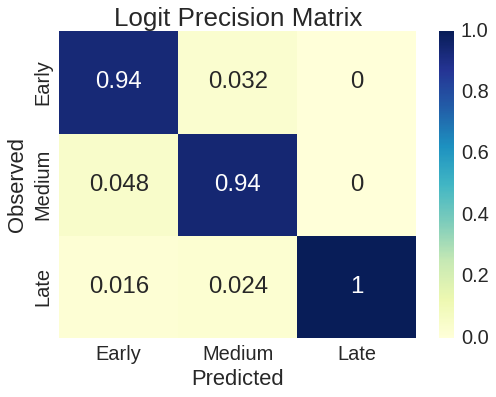

In [36]:
conf_matrix = confusion_matrix(y_train, y_pred)

# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Medium', 'Late'],
           yticklabels = ['Early', 'Medium', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('LinearSVC Precision Matrix', fontsize=26)
plt.show()

## SGD

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_default = SGDClassifier(random_state=42)

# shuffle data
np.random.seed(101)
shuffle_index = np.random.permutation(np.shape(X_train_s)[0])
shuffled_X_train_s, shuffled_y_train = X_train_s[shuffle_index], y_train[shuffle_index]

y_pred = report_res(sgd_default, shuffled_X_train_s, shuffled_y_train, 'macro')

0.937403993856
             precision    recall  f1-score   support

          0       0.92      0.92      0.92        62
          1       0.92      0.95      0.94       122
          2       0.97      0.88      0.92        40

avg / total       0.93      0.93      0.93       224



In [39]:
sgd = SGDClassifier(random_state=42) # default loss and penalty

#'n_iter':[np.ceil(10**6/X_train_s.shape[0])],
param_grid = {
             'alpha': 10.0**-np.arange(1,7)}



sgd_search_param = GridSearchCV(sgd, param_grid=param_grid,
                             scoring='precision_macro',n_jobs=6,iid=False,
                             cv = 5)

sgd_search_param.fit(shuffled_X_train_s, shuffled_y_train)
print(sgd_search_param.best_params_)
print(sgd_search_param.best_estimator_)

y_pred=report_res(sgd_search_param, shuffled_X_train_s, shuffled_y_train, 'macro')

{'alpha': 0.0001}
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)
0.881550431468
             precision    recall  f1-score   support

          0       0.91      0.84      0.87        62
          1       0.90      0.91      0.90       122
          2       0.84      0.90      0.87        40

avg / total       0.89      0.89      0.89       224



In [27]:
y_pred = sgd_search_param.predict(shuffled_X_train_s)
print(precision_score(shuffled_y_train, y_pred, average = 'macro'))

1.0
